# **A. Preparation**

This section is used to import necessary library, data and reformat them if necessary

## **1. Import necessary library**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sqlalchemy import create_engine

from calendar import monthrange
from datetime import timedelta
from datetime import datetime
from dateutil.relativedelta import relativedelta

from ortools.linear_solver import pywraplp

from collections import defaultdict
from pprint import pprint

import copy

## **2. Import Data**

### **2.1. Import SQL**

#### 2.1.1. Bill of Material

In [77]:
#Khal båo credential
str_user = 'user_schf'
str_password = '11223344'
str_db = 'db_schf_round3'
#Tạo connection
engine = create_engine(
  f"postgresql://{str_user}:{str_password }@139.180.184.67:5432/{str_db}?sslmode=require"
)
connection = engine.connect()

#Đọc bång INPUT_BOX
df_bom = pd.read_sql("""select * from INPUT_BOM""", con=connection)
bom_dict = {}
unique_items = df_bom['THÀNH PHẨM'].unique()
for item in unique_items:
    bom = df_bom[df_bom['THÀNH PHẨM'] == item]
    unique_raw_items = bom['NGUYÊN LIỆU'].unique()
    bom_dict[item] = {}
    for raw_item in unique_raw_items:
        n = bom.columns[2]
        quantity = bom[bom['NGUYÊN LIỆU'] == raw_item][n].values[0]
        bom_dict[item][raw_item] = quantity

#### 2.1.2. Raw Material Ìnformation

In [78]:
df_items_fg = pd.read_sql("""select * from INPUT_ITEMMASTER""", con=connection)
# fill nan with 1000
df_items_fg = df_items_fg.fillna(1000)
df_items_fg

,ITEM,LOẠI,NHÀ CUNG CẤP,LEADTIME ĐẶT HÀNG (NGÀY),MOQ,ĐƠN VỊ
0,KHOAI,Nguyên liệu,CÔNG TY TNHH NARGI,7,3000.0,kg
1,SẮN,Nguyên liệu,CÔNG TY TNHH NARGI,7,1500.0,kg
2,NGÔ,Nguyên liệu,CÔNG TY TNHH NARGI,7,3000.0,kg
3,BỘT_ĐỖ_TƯƠNG,Nguyên liệu,CÔNG TY TNHH NARGI,7,1500.0,kg
4,THÓC,Nguyên liệu,CÔNG TY TNHH NARGI,7,3000.0,kg
5,XƯƠNG_ĐỘNG_VẬT,Nguyên liệu,CÔNG TY CP YFOOD,7,1000.0,kg
6,MEN_VI_SINH,Nguyên liệu,CÔNG TY VNIBIO,2,100.0,lít
7,BAO_BÌ_25KG,Nguyên liệu,CÔNG TY TNHH WOPACK,7,1000.0,cái
8,BAO_BÌ_40KG,Nguyên liệu,CÔNG TY TNHH WOPACK,7,1000.0,cái


### **2.2. Import Google Sheet**

#### 2.2.1 Demand

In [79]:
db_demand='https://github.com/binhdam/SCHackFestRound3/raw/main/INPUT_DEMAND.xlsx'

xl = pd.ExcelFile('https://github.com/binhdam/SCHackFestRound3/raw/main/INPUT_DEMAND.xlsx')
markets = xl.sheet_names  # see all sheet names

# import demand dataframe into a dictionary
df_demand={}
for market in markets:
  df_demand[market]  = pd.read_excel(db_demand,sheet_name=market)

#### 2.2.2 Stock on hand

In [80]:
db_soh='https://github.com/binhdam/SCHackFestRound3/raw/main/INPUT_SUPPLY_SOH.xlsx'

xl=pd.ExcelFile('https://github.com/binhdam/SCHackFestRound3/raw/main/INPUT_SUPPLY_SOH.xlsx')
locations=xl.sheet_names

# import stock-on-hand dataframe into a dictionary
df_soh={}
for location in locations:
  df_soh[location] = pd.read_excel(db_soh,sheet_name=location)

### **2.3. Import PO Data**

In [81]:
PO_dict={}
PO_sheet=[]
PO_sheet.append("https://github.com/schackfest/round3data/raw/main/PO997_ongoing.xlsx?raw=true")
PO_sheet.append("https://github.com/schackfest/round3data/raw/main/PO998_ongoing.xlsx?raw=true")
for PO in PO_sheet:
  df_PO = pd.read_excel(PO)
  number_of_items=max([i for i in df_PO['ĐƠN ĐẶT HÀNG'].values if isinstance(i, int)])
  PO_num = df_PO['Unnamed: 4'][1]    #Mã đặt hàng
  # PO_dict[PO_num]={}
  # create default dict with value is list
  PO_dict[PO_num] = []
  """count xem có bao nhiêu thằng trong mã PO này, để tạo từng đầy row"""
  for i in range(number_of_items):
    tmp_dict = {}
    tmp_dict["item"] = df_PO['Unnamed: 1'][7+i]
    tmp_dict["quantity"] = df_PO['Unnamed: 2'][7+i]
    tmp_dict["unit"]= df_PO['Unnamed: 3'][7+i]
    tmp_dict["expiry_date"]=pd.to_datetime(
                                str(df_PO['Unnamed: 6'][7+i])
                                [(str(df_PO['Unnamed: 6'][7+i]).find(':')+1):].lstrip(),
                                 format='%d-%b-%Y')#date có dạng dd-MMM-YYYY
    # check tmp_dict["expiry_date"] is NaT
    if tmp_dict["expiry_date"] != tmp_dict["expiry_date"]:
      tmp_dict["expiry_date"] = pd.to_datetime('31-Dec-2100', format='%d-%b-%Y')
    arrival_date_cell = df_PO[df_PO['Unnamed: 1'].str.contains('Thời gian giao hàng') == True]['Unnamed: 1'].values[0]
    tmp_dict["arrival_date"] = pd.to_datetime(
                        arrival_date_cell[arrival_date_cell.find(':')+1:].lstrip()
                        ,format='%d-%b-%Y')
    PO_dict[PO_num].append(tmp_dict)

# PO_dict
po_list = []
for k, v in PO_dict.items():
  for item in v:
    po_list.append(item)
po_list

[{'item': 'BAO_BÌ_25KG',
  'quantity': 800,
  'unit': 'cái',
  'expiry_date': Timestamp('2100-12-31 00:00:00'),
  'arrival_date': Timestamp('2023-04-01 00:00:00')},
 {'item': 'BAO_BÌ_40KG',
  'quantity': 200,
  'unit': 'cái',
  'expiry_date': Timestamp('2100-12-31 00:00:00'),
  'arrival_date': Timestamp('2023-04-01 00:00:00')},
 {'item': 'BỘT_ĐỖ_TƯƠNG',
  'quantity': 2000,
  'unit': 'kg',
  'expiry_date': Timestamp('2023-07-14 00:00:00'),
  'arrival_date': Timestamp('2023-04-05 00:00:00')},
 {'item': 'THÓC',
  'quantity': 4000,
  'unit': 'kg',
  'expiry_date': Timestamp('2023-07-14 00:00:00'),
  'arrival_date': Timestamp('2023-04-05 00:00:00')}]

# **B. Main Algorithm**

This section is used to perform the main algorithm to get the output. It consists of two main steps:

1. Create MPS with Simplex LP (Optimization)
2. Create MRP from MPS and Inventory Status

## **1. Create MPS with Optimization**

In [82]:
start_date = datetime(2023, 2, 20)
action_date = datetime(2023, 4, 1)
end_date = datetime(2023, 6, 30)
total_day = end_date - start_date + timedelta(days=1)

### 2.1. Define useful functions

In [83]:
def table_info(day, var, inventory=None, product=None):
    global df_soh_chicken, start_date
    num_product_oh = 0
    day = start_date + timedelta(days=day)
    if var == "X":
        num_product_oh = 0
        for k, v in df_soh_chicken.items():
            tmp = v[v['nsx'] == day]
            num_product_oh += tmp[tmp['item'] == product]['qty'].sum()
    elif var == "Y":
        v = df_soh_chicken[inventory]
        v = v[v['nsx'] == day]
        num_product_oh = v[v['item'] == product]['qty'].sum()
    else:
        raise Exception("var must be X or Y")

    return num_product_oh

def day_in_soh(df, start_date):
    lis = []
    for v in df.values():
        for nsx in v["nsx"]:
            if nsx not in lis:
                lis.append(nsx)
    lis = sorted([(x - start_date).days for x in lis])
    return lis

def find_sunday(start_date, end_date):
    lis = []
    for i in range((end_date - start_date).days + 1):
        day = start_date + timedelta(days=i)
        if day.weekday() == 6:
            lis.append(i)
    return lis

def find_day_start_month(start_date, end_date):
    lis = []
    for i in range((end_date - start_date).days + 1):
        day = start_date + timedelta(days=i)
        if day.day == 1:
            lis.append(i)
    return lis

def find_day_end_month(start_date, end_date):
    lis = []
    for i in range((end_date - start_date).days + 2):
        day = start_date + timedelta(days=i)
        if day.day == 1:
            lis.append(i - 1)
    return lis

def find_24_day(start_date, end_date):
    lis = []
    for i in range((end_date - start_date).days + 1):
        day = start_date + timedelta(days=i)
        if day.weekday() == 0 or day.weekday() == 2:
            lis.append(i)
    return lis


In [84]:
def f(day, warehouse):
    global T
    day = day if warehouse == 0 else day - 1
    for i in T[::-1]:
      if i <= day:
        return i
    return -1

def g(day, warehouse):
    global T, MAX_HSD
    # relax it, suppose MAX_HSD is much higher delay time and transport time
    return max(day - MAX_HSD, 0)


### 2.2. Problem Formulation and Optimize Production Plan

#### 2.2.1. Chicken

##### 2.2.1.1. Input

In [85]:
# Plan for WOW_CHICKEN
chicken_alias = ["WOW_CHICKEN_25KG", "WOW_CHICKEN_40KG"]
df_demand_chicken = {}
for k, v in df_demand.items():
    df_demand_chicken[k] = v[v['ITEM'].isin(chicken_alias)]
df_demand_chicken_arr = np.zeros((3, 2, 2)) # 3 months, 2 city, 2 product
for i, city in enumerate(df_demand_chicken.keys()):
  for j, (_, row) in enumerate(df_demand_chicken[city].iterrows()):
    df_demand_chicken_arr[0, i, j] = row['APR_2023']
    df_demand_chicken_arr[1, i, j] = row['MAY_2023']
    df_demand_chicken_arr[2, i, j] = row['JUN_2023']

In [86]:
N = list(range(total_day.days))
N_star = day_in_soh(df_soh_chicken, start_date)
N_bar = list(range((action_date - start_date).days))
N_off = find_sunday(start_date, end_date)
MAX_CAPACITY = 3000
P = df_demand_chicken_arr
MAX_HSD = 30  #day
S = find_day_start_month(start_date, end_date)[1:]
E = find_day_end_month(start_date, end_date)[2:]
T = find_24_day(start_date, end_date)

In [87]:
df_soh_chicken = {}
for w in df_soh.keys():
    df_soh_chicken[w] = df_soh[w][df_soh[w]['ITEM'].isin(chicken_alias)]
for i, k in enumerate(df_soh_chicken.keys()):
    print(i, k)
    df_soh_chicken[i] = df_soh_chicken.pop(k).rename(columns={'ITEM': 'item', 'TỒN KHO CUỐI NGÀY 31/3/2023': 'qty', 'NGÀY SẢN XUẤT':"nsx", 'HẠN SỬ DỤNG TRÊN BAO BÌ':"hsd"})
mapping = {"WOW_CHICKEN_25KG": 0, "WOW_CHICKEN_40KG": 1}
for k, v in df_soh_chicken.items():
    df_soh_chicken[k] = v.assign(item=v['item'].map(mapping))
# format nsx to datatime
for k, v in df_soh_chicken.items():
    df_soh_chicken[k]['nsx'] = pd.to_datetime(v['nsx'], format='%d/%m/%Y')
    df_soh_chicken[k]['hsd'] = pd.to_datetime(v['hsd'], format='%d/%m/%Y')
df_soh_chicken

0 Đông Nam Bộ
1 Đồng bằng Sông Cửu Long
2 Nhà máy


{0:    item    qty ĐƠN VỊ        nsx        hsd
 3     0  362.0    bao 2023-03-28 2023-05-27
 4     1  100.0    bao 2023-03-28 2023-05-27,
 1:    item    qty ĐƠN VỊ        nsx        hsd
 3     0  754.0    bao 2023-03-27 2023-05-26
 4     0  112.0    bao 2023-03-19 2023-05-18
 5     0   30.0    bao 2023-02-20 2023-04-21
 6     1  369.0    bao 2023-03-27 2023-05-26,
 2:     item    qty ĐƠN VỊ        nsx        hsd
 13     0  307.0    bao 2023-03-29 2023-05-28
 14     1  117.0    bao 2023-03-29 2023-05-28}

##### 2.2.1.2. Problem Formulation

###### a. Decision Variables

In [88]:
#Create Decision Variables
solver = pywraplp.Solver.CreateSolver("SCIP")
X = {}     #production
Y = {}     #ship from factory to warehouse
Z = {}     #ship from warehouse to customer
a = {}
b = {}
Z_star = {}
M_BIG = 1e9     #a big number

for i in N:
    for j in range(2):
        X[i, j] = solver.NumVar(0, solver.infinity(), 'X[%i,%i]' % (i, j))
        for k in range(2):
            Y[i, j, k] = solver.NumVar(0, solver.infinity(), 'Y[%i,%i,%i]' % (i, j, k))
            Z[i, j, k] = solver.NumVar(0, solver.infinity(), 'z[%i,%i,%i]' % (i, j, k))
            # b[i, j, k] = solver.BoolVar('b[%i,%i,%i]' % (i, j, k))
            if i < len(S):
                # TODO: fix me if there is no feasible solution
                a[i, j, k] = solver.NumVar(0, solver.infinity(), 'a[%i,%i,%i]' % (i, j, k))
                Z_star[i, j, k] = solver.NumVar(0, solver.infinity(), 'Z_star[%i,%i,%i]' % (i, j, k))
                # Z_star[i, j, k] = solver.NumVar(0, 10, 'Z_star[%i,%i,%i]' % (i, j, k))

###### b. Constraints

In [89]:
# Create the constraints
for i in N_bar + N_off:
    if i not in N_star:
        for j in range(2):
            solver.Add(X[i, j] == 0)
            for k in range(2):
                solver.Add(Y[i, j, k] == 0)

# for i in N_bar:
for i in N_bar + N_off:
    for j in range(2):
        for k in range(2):
            solver.Add(Z[i, j, k] == 0)

for i in N_star:
    for j in range(2):
        solver.Add(X[i, j] == table_info(i, 'X', product=j))
        for k in range(2):
            vals = table_info(i, "Y", inventory=j, product=k)
            if vals > 0:
                solver.Add(Y[i, j, k] == table_info(i, "Y", inventory=j, product=k))

for i in N:
    if i not in N_off and i not in N_star:
        solver.Add(25 * X[i, 0] + 40 * X[i, 1] <= MAX_CAPACITY)

for i in N:
    solver.Add(Y[i, 0, 0] + Y[i, 1, 0] == X[i, 0])
    solver.Add(Y[i, 0, 1] + Y[i, 1, 1] == X[i, 1])

for s, e in zip(S, E):
    for j in range(2):
        c1 = solver.Constraint(0, 0)
        for i in range(s, e):
            c1.SetCoefficient(Z[i, j, 0], -0.7)
            c1.SetCoefficient(Z[i, j, 1], -0.7)
            if i >= e - 14:
                c1.SetCoefficient(Z[i, j, 0], 1)
                c1.SetCoefficient(Z[i, j, 1], 1)

for j in range(2):
    for k in range(2):
        for x in range(len(E)):
            c2 = solver.Constraint(P[x, j, k], P[x, j, k])
            c2.SetCoefficient(a[x, j, k], 1)
            for i in range(S[x], E[x]):
                c2.SetCoefficient(Z[i, j, k], 1)

for i in N:
    for j in range(2):
        for k in range(2):
            c3 = solver.Constraint(-solver.infinity(), 0)
            c3.SetCoefficient(Z[i, j, k], 1)
            gv = g(i, j)
            fv = f(i, j)
            if fv < 0:
                continue
            for m in range(g(i, j), f(i, j)):
                c3.SetCoefficient(Y[m, j, k], -1)

for m in N:
    for j in range(2):
        for k in range(2):
            c4 = solver.Constraint(-solver.infinity(), 0)
            for i in range(m+1):
                c4.SetCoefficient(Z[i, j, k], 1)
            fv = f(m + 1, j)
            if fv < 0:
                continue
            for i in range(fv):
                c4.SetCoefficient(Y[i, j, k], -1)

# for x, (s, e) in enumerate(zip(S, E)):
#     for i in range(s, e):
#         if i not in N_off:
#             for j in range(2):
#                 for k in range(2):
#                     c5 = solver.Add(Z_star[x, j, k] <= Z[i, j, k])
#                     c6 = solver.Add(Z_star[x, j, k] >= Z[i, j, k] - M_BIG * b[i, j, k])

###### c. Objective Function

In [90]:
# Create the objective function, change the coefficient of the variables.
objective = solver.Objective()
for i in N:
    for j in range(2):
        for k in range(2):
            objective.SetCoefficient(Z[i, j, k], -1)
            objective.SetCoefficient(Y[i, j, k], 1)
            if i < len(S):
                objective.SetCoefficient(a[i, j, k], 1000)
                # objective.SetCoefficient(Z_star[i, j, k], -1)
objective.SetMinimization()
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())
status = solver.Solve()
print("Status: ", status)

Number of variables = 1334
Number of constraints = 1997
Status:  0


In [91]:
#Handle different situations
if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    sum_a = 0
    for i in range(len(S)):
        for j in range(2):
            for k in range(2):
                v = a[i, j, k].solution_value()
                sum_a += v
    sum_x = 0
    sum_x0 = 0
    sum_x1 = 0
    for i in N:
        for j in range(2):
            sum_x += X[i, j].solution_value()
            if j == 0:
                sum_x0 += X[i, j].solution_value()
            else:
                sum_x1 += X[i, j].solution_value()
    for j in range(2):
        for k in range(2):
            sum_z = 0
            sum_y = 0
            for i in N:
                sum_z += Z[i, j, k].solution_value()
                sum_y += Y[i, j, k].solution_value()
    sum_y = 0
    for i in N:
        for j in range(2):
            for k in range(2):
                sum_y += Y[i, j, k].solution_value()
    sum_z = 0
    for i in N:
        for j in range(2):
            for k in range(2):
                sum_z += Z[i, j, k].solution_value()
    print("sum x: ", sum_x)
    print("sum a: ", sum_a)
    print("sum y: ", sum_y)
    print("sum z: ", sum_z)
    print("sum x0: ", sum_x0)
    print("sum x1: ", sum_x1)
else:
    print('The problem does not have an optimal solution.')

Objective value = 392125.0
sum x:  9907.875
sum a:  392.12500000000136
sum y:  9907.875
sum z:  9907.874999999998
sum x0:  7249.999999999997
sum x1:  2657.8750000000014


In [92]:
X_Results_Chicken = np.zeros((len(N), 2))
Y_Results_Chicken = np.zeros((len(N), 2, 2))
Z_Results_Chicken = np.zeros((len(N), 2, 2))
a_Results_Chicken = np.zeros((len(S), 2, 2))
for i in N:
    for j in range(2):
        X_Results_Chicken[i, j] = X[i, j].solution_value()
        for k in range(2):
            Y_Results_Chicken[i, j, k] = Y[i, j, k].solution_value()
            Z_Results_Chicken[i, j, k] = Z[i, j, k].solution_value()
            if i < len(S):
                  a_Results_Chicken[i, j, k] = a[i, j, k].solution_value()

#### 2.2.2. Sheep

##### 2.2.2.1. Input

In [93]:
# Plan for STAR_SHEEP
sheep_alias = ["STAR_SHEEP_25KG", "STAR_SHEEP_40KG"]
df_demand_sheep = {}
for k, v in df_demand.items():
    df_demand_sheep[k] = v[v['ITEM'].isin(sheep_alias)]
df_demand_sheep_arr = np.zeros((3, 2, 2)) # 3 months, 2 city, 2 product
for i, city in enumerate(df_demand_sheep.keys()):
  for j, (_, row) in enumerate(df_demand_sheep[city].iterrows()):
    df_demand_sheep_arr[0, i, j] = row['APR_2023']
    df_demand_sheep_arr[1, i, j] = row['MAY_2023']
    df_demand_sheep_arr[2, i, j] = row['JUN_2023']

In [94]:
df_soh_sheep = {}
for w in df_soh.keys():
    df_soh_sheep[w] = df_soh[w][df_soh[w]['ITEM'].isin(sheep_alias)]
for i, k in enumerate(df_soh_sheep.keys()):
    print(i, k)
    df_soh_sheep[i] = df_soh_sheep.pop(k).rename(columns={'ITEM': 'item', 'TỒN KHO CUỐI NGÀY 31/3/2023': 'qty', 'NGÀY SẢN XUẤT':"nsx", 'HẠN SỬ DỤNG TRÊN BAO BÌ':"hsd"})
mapping = {"STAR_SHEEP_25KG": 0, "STAR_SHEEP_40KG": 1}
for k, v in df_soh_sheep.items():
    df_soh_sheep[k] = v.assign(item=v['item'].map(mapping))
# format nsx to datatime
for k, v in df_soh_sheep.items():
    df_soh_sheep[k]['nsx'] = pd.to_datetime(v['nsx'], format='%d/%m/%Y')
    df_soh_sheep[k]['hsd'] = pd.to_datetime(v['hsd'], format='%d/%m/%Y')
df_soh_sheep

0 Đông Nam Bộ
1 Đồng bằng Sông Cửu Long
2 Nhà máy


{0:    item    qty ĐƠN VỊ        nsx        hsd
 0     0  146.0    bao 2023-03-28 2023-05-27
 1     0   30.0    bao 2023-03-28 2023-05-27
 2     1  110.0    bao 2023-03-28 2023-05-27,
 1:    item    qty ĐƠN VỊ        nsx        hsd
 0     0  208.0    bao 2023-03-27 2023-05-26
 1     1  115.0    bao 2023-03-24 2023-05-23
 2     1   20.0    bao 2023-03-27 2023-05-26,
 2:     item   qty ĐƠN VỊ        nsx        hsd
 11     0  97.0    bao 2023-03-30 2023-05-29
 12     1  54.0    bao 2023-03-30 2023-05-29}

In [95]:
def table_info(day, var, inventory=None, product=None):
    global df_soh_sheep, start_date
    num_product_oh = 0
    day = start_date + timedelta(days=day)
    if var == "X":
        num_product_oh = 0
        for k, v in df_soh_sheep.items():
            tmp = v[v['nsx'] == day]
            num_product_oh += tmp[tmp['item'] == product]['qty'].sum()
    elif var == "Y":
        v = df_soh_sheep[inventory]
        v = v[v['nsx'] == day]
        num_product_oh = v[v['item'] == product]['qty'].sum()
    else:
        raise Exception("var must be X or Y")

    return num_product_oh

In [96]:
N = list(range(total_day.days))
N_star = day_in_soh(df_soh_sheep, start_date)
N_bar = list(range((action_date - start_date).days))
N_off = find_sunday(start_date, end_date)
MAX_CAPACITY = 2000
P = df_demand_sheep_arr
MAX_HSD = 30  #day
S = find_day_start_month(start_date, end_date)[1:]
E = find_day_end_month(start_date, end_date)[2:]
T = find_24_day(start_date, end_date)

##### 2.2.2.2. Problem Formulation

###### a. Decision Variables

In [97]:
solver = pywraplp.Solver.CreateSolver("SCIP")
X = {}
Y = {}
Z = {}
a = {}
b = {}
Z_star = {}
M_BIG = 1e9

for i in N:
    for j in range(2):
        X[i, j] = solver.NumVar(0, solver.infinity(), 'X[%i,%i]' % (i, j))
        for k in range(2):
            Y[i, j, k] = solver.NumVar(0, solver.infinity(), 'Y[%i,%i,%i]' % (i, j, k))
            Z[i, j, k] = solver.NumVar(0, solver.infinity(), 'z[%i,%i,%i]' % (i, j, k))
            # b[i, j, k] = solver.BoolVar('b[%i,%i,%i]' % (i, j, k))
            if i < len(S):
                # TODO: fix me if there is no feasible solution
                a[i, j, k] = solver.NumVar(0, solver.infinity(), 'a[%i,%i,%i]' % (i, j, k))
                Z_star[i, j, k] = solver.NumVar(0, solver.infinity(), 'Z_star[%i,%i,%i]' % (i, j, k))
                # Z_star[i, j, k] = solver.NumVar(0, 10, 'Z_star[%i,%i,%i]' % (i, j, k))

###### b. Constraints

In [98]:
# Create the constraints.
for i in N_bar + N_off:
    if i not in N_star:
        for j in range(2):
            solver.Add(X[i, j] == 0)
            for k in range(2):
                solver.Add(Y[i, j, k] == 0)

# for i in N_bar:
for i in N_bar + N_off:
    for j in range(2):
        for k in range(2):
            solver.Add(Z[i, j, k] == 0)

for i in N_star:
    for j in range(2):
        solver.Add(X[i, j] == table_info(i, 'X', product=j))
        for k in range(2):
            vals = table_info(i, "Y", inventory=j, product=k)
            if vals > 0:
                solver.Add(Y[i, j, k] == table_info(i, "Y", inventory=j, product=k))

for i in N:
    if i not in N_off and i not in N_star:
        solver.Add(25 * X[i, 0] + 40 * X[i, 1] <= MAX_CAPACITY)

for i in N:
    solver.Add(Y[i, 0, 0] + Y[i, 1, 0] == X[i, 0])
    solver.Add(Y[i, 0, 1] + Y[i, 1, 1] == X[i, 1])

for s, e in zip(S, E):
    for j in range(2):
        c1 = solver.Constraint(0, 0)
        for i in range(s, e):
            c1.SetCoefficient(Z[i, j, 0], -0.7)
            c1.SetCoefficient(Z[i, j, 1], -0.7)
            if i >= e - 14:
                c1.SetCoefficient(Z[i, j, 0], 1)
                c1.SetCoefficient(Z[i, j, 1], 1)

for j in range(2):
    for k in range(2):
        for x in range(len(E)):
            c2 = solver.Constraint(P[x, j, k], P[x, j, k])
            c2.SetCoefficient(a[x, j, k], 1)
            for i in range(S[x], E[x]):
                c2.SetCoefficient(Z[i, j, k], 1)

for i in N:
    for j in range(2):
        for k in range(2):
            c3 = solver.Constraint(-solver.infinity(), 0)
            c3.SetCoefficient(Z[i, j, k], 1)
            gv = g(i, j)
            fv = f(i, j)
            if fv < 0:
                continue
            for m in range(g(i, j), f(i, j)):
                c3.SetCoefficient(Y[m, j, k], -1)

for m in N:
    for j in range(2):
        for k in range(2):
            c4 = solver.Constraint(-solver.infinity(), 0)
            for i in range(m+1):
                c4.SetCoefficient(Z[i, j, k], 1)
            fv = f(m + 1, j)
            if fv < 0:
                continue
            for i in range(fv):
                c4.SetCoefficient(Y[i, j, k], -1)

# for x, (s, e) in enumerate(zip(S, E)):
#     for i in range(s, e):
#         if i not in N_off:
#             for j in range(2):
#                 for k in range(2):
#                     c5 = solver.Add(Z_star[x, j, k] <= Z[i, j, k])
#                     c6 = solver.Add(Z_star[x, j, k] >= Z[i, j, k] - M_BIG * b[i, j, k])



###### c. Objective Function

In [99]:
# Create the objective function, change the coefficient of the variables.
objective = solver.Objective()
for i in N:
    for j in range(2):
        for k in range(2):
            objective.SetCoefficient(Z[i, j, k], -1)
            objective.SetCoefficient(Y[i, j, k], 1)
            if i < len(S):
                objective.SetCoefficient(a[i, j, k], 1000)
                # objective.SetCoefficient(Z_star[i, j, k], -1)
objective.SetMinimization()
print('Number of variables =', solver.NumVariables())
print('Number of constraints =', solver.NumConstraints())
status = solver.Solve()
print("Status: ", status)

Number of variables = 1334
Number of constraints = 2006
Status:  0


In [100]:
#Handle different situations
if status == pywraplp.Solver.OPTIMAL:
    print('Objective value =', solver.Objective().Value())
    # sum a
    sum_a = 0
    for i in range(len(S)):
        for j in range(2):
            for k in range(2):
                v = a[i, j, k].solution_value()
                sum_a += v

    sum_x = 0
    sum_x0 = 0
    sum_x1 = 0
    for i in N:
        for j in range(2):
            sum_x += X[i, j].solution_value()
            if j == 0:
                sum_x0 += X[i, j].solution_value()
            else:
                sum_x1 += X[i, j].solution_value()
    for j in range(2):
        for k in range(2):
            sum_z = 0
            sum_y = 0
            for i in N:
                sum_z += Z[i, j, k].solution_value()
                sum_y += Y[i, j, k].solution_value()

    sum_y = 0
    for i in N:
        for j in range(2):
            for k in range(2):
                sum_y += Y[i, j, k].solution_value()
    sum_z = 0
    for i in N:
        for j in range(2):
            for k in range(2):
                sum_z += Z[i, j, k].solution_value()

    print("sum x: ", sum_x)
    print("sum a: ", sum_a)
    print("sum y: ", sum_y)
    print("sum z: ", sum_z)
    print("sum x0: ", sum_x0)
    print("sum x1: ", sum_x1)
    # for i in N:
    #     for j in range(2):
    #         print('X[%i,%i] = %i' % (i, j, X[i, j].solution_value()))
    #         # for k in range(2):
            #     print('Z[%i,%i,%i] = %i' % (i, j, k, Z[i, j, k].solution_value()))
            #     print('Y[%i,%i,%i] = %i' % (i, j, k, Y[i, j, k].solution_value()))
                # if i < 3:
                    # print('a[%i,%i,%i] = %i' % (i, j, k, a[i, j, k].solution_value()))
else:
    print('The problem does not have an optimal solution.')

Objective value = 4.656612873077393e-10
sum x:  5750.714705882353
sum a:  6.758533762208354e-13
sum y:  5750.714705882353
sum z:  5750.714705882349
sum x0:  3867.2588235294106
sum x1:  1883.4558823529421


In [101]:
X_Results_SHEEP = np.zeros((len(N), 2))
Y_Results_SHEEP = np.zeros((len(N), 2, 2))
Z_Results_SHEEP = np.zeros((len(N), 2, 2))
a_Results_SHEEP = np.zeros((len(S), 2, 2))
for i in N:
    for j in range(2):
        X_Results_SHEEP[i, j] = X[i, j].solution_value()
        for k in range(2):
            Y_Results_SHEEP[i, j, k] = Y[i, j, k].solution_value()
            Z_Results_SHEEP[i, j, k] = Z[i, j, k].solution_value()
            if i < len(S):
                  a_Results_SHEEP[i, j, k] = a[i, j, k].solution_value()

Tính thêm lượng hao hụt trong quá trình sản xuất (hao hụt 2%)

In [102]:
loss = 0.02

X_Results_SHEEP = X_Results_SHEEP * 1/(1-loss)
X_Results_Chicken = X_Results_Chicken * 1/(1-loss)

## **2. Calculate MRP**

### 2.1. Tính toán Missing Raw Material Per Day

Ở phần này, để tính được missing ingredient, chúng ta cần thực hiện các bước lần lượt như sau (output của bước trước dùng cho bươc sau).


|Step| Output | Input |
|---| --- | --- |
|1| MPS | Refer to Optimization model above |
|2| Raw Material Gross Requirement| MPS <br>BOM |
|3| Missing Raw Material | Raw Material Gross Requirement<br> Raw Material Inventory Status|

In [103]:
ingre = []
for k, v in bom_dict.items():
    for k in v.keys():
        if k not in ingre:
            ingre.append(k)
default_bom = {i:0 for i in ingre}
history_missing_ingredient = {i:copy.deepcopy(default_bom) for i in range(X_Results_SHEEP.shape[0])}
for day, (chicken, sheep) in enumerate(zip(X_Results_Chicken, X_Results_SHEEP)):
    chicken_25 = chicken[0]
    chicken_40 = chicken[1]
    sheep_25 = sheep[0]
    sheep_40 = sheep[1]
    for k, v in bom_dict["WOW_CHICKEN_25KG"].items():
        history_missing_ingredient[day][k] += chicken_25 * v
    for k, v in bom_dict["WOW_CHICKEN_40KG"].items():
        history_missing_ingredient[day][k] += chicken_40 * v
    for k, v in bom_dict["STAR_SHEEP_25KG"].items():
        history_missing_ingredient[day][k] += sheep_25 * v
    for k, v in bom_dict["STAR_SHEEP_40KG"].items():
        history_missing_ingredient[day][k] += sheep_40 * v

# history_missing_ingredient

In [104]:
df_soh_ingre = df_soh["Nhà máy"][df_soh["Nhà máy"]["ITEM"].isin(ingre)]
#fill NaT = 100000
df_soh_ingre

,ITEM,TỒN KHO CUỐI NGÀY 31/3/2023,ĐƠN VỊ,NGÀY SẢN XUẤT,HẠN SỬ DỤNG TRÊN BAO BÌ
0,NGÔ,7341.0,kg,2023-03-10,2023-06-22
1,NGÔ,1200.0,kg,2023-03-06,2023-06-18
2,KHOAI,7195.0,kg,2023-03-09,2023-06-21
3,SẮN,1999.0,kg,2023-03-02,2023-06-14
4,BỘT_ĐỖ_TƯƠNG,1817.0,kg,2023-02-20,2023-06-04
5,THÓC,7123.0,kg,2023-02-20,2023-06-04
6,XƯƠNG_ĐỘNG_VẬT,5202.0,kg,2023-03-22,2023-04-25
7,MEN_VI_SINH,727.0,lít,2023-03-31,2023-05-04
8,MEN_VI_SINH,100.0,lít,2023-03-26,2023-04-29
9,BAO_BÌ_25KG,1125.0,cái,NaT,NaT


In [105]:
hsd_dict = {}
for i in ingre:
    nsx = df_soh_ingre[df_soh_ingre["ITEM"] == i]["NGÀY SẢN XUẤT"].values[0]
    hsd = df_soh_ingre[df_soh_ingre["ITEM"] == i]["HẠN SỬ DỤNG TRÊN BAO BÌ"].values[0]
    d = (hsd - nsx).astype('timedelta64[D]').astype(int)
    if d < 0:
        d = 1000000000
    hsd_dict[i] = d * 0.5

hsd_dict

{'NGÔ': 52.0,
 'KHOAI': 52.0,
 'SẮN': 52.0,
 'XƯƠNG_ĐỘNG_VẬT': 17.0,
 'MEN_VI_SINH': 17.0,
 'BAO_BÌ_25KG': 500000000.0,
 'BAO_BÌ_40KG': 500000000.0,
 'BỘT_ĐỖ_TƯƠNG': 52.0,
 'THÓC': 52.0}

### 2.2. Define Useful Functions

In [106]:
# Tìm ra ngày thiếu đầu tiên của nguyên vật liệu đó. Loop danh sách, ngày có số lượng nguyên vật liệu cần nhập vào lớn hơn 0 thì đó ngày thiếu sản phẩm
def start_insufficient(lis):
    for i in range(len(lis)):
        if lis[i] > 0:
            return i
    return len(lis)

# Tính tổng số lượng cần import
def get_amount_import(lis, start, end):
    # return lis[end] if end < len(lis) else lis[-1]
    return sum(lis[start:end]) if lis[start:end] else 0

# Check số lượng raw material có thỏa mãn điều kiện MOQ hay không
def check_moq(amout, moq):
    return amout > moq

# Kiểm tra xem còn hàng trong kho không? Nếu còn thì không cần nhập nữa
def check_finish(t_y_dict):
    for value in t_y_dict.values():
        if sum(value) > 0:
            return False
    return True

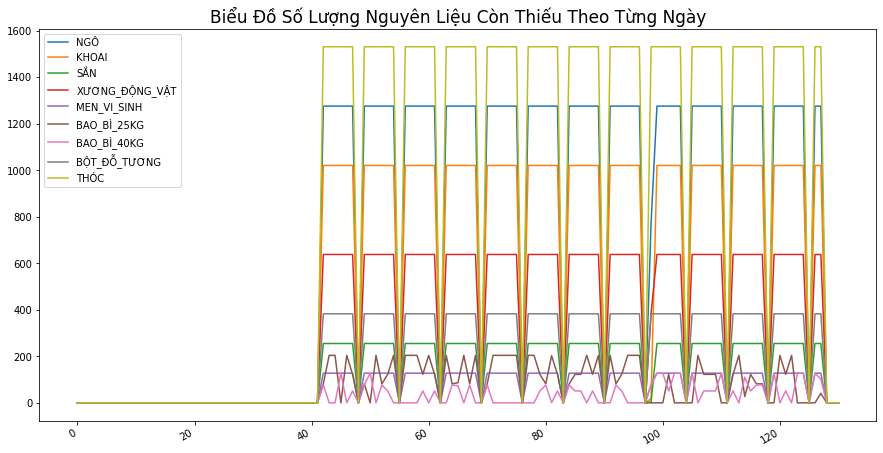

In [107]:
x = [i for i in history_missing_ingredient.keys()]
y_dict = {}
for item in ingre:
    y_dict[item] = [j[item] if i > (action_date - start_date).days else 0 for i, j in enumerate(history_missing_ingredient.values())]

for key in y_dict.keys():
    plt.plot(x, y_dict[key], label=key)
    plt.title("Biểu Đồ Số Lượng Nguyên Liệu Còn Thiếu Theo Từng Ngày", fontsize=17)
    plt.gcf().set_size_inches(15, 8)
    plt.gcf().autofmt_xdate()
    plt.legend()

In [108]:
dic_soh_ingre = {}
# loop through all df_soh_ingre
for index, row in df_soh_ingre.iterrows():
    hsd = row["HẠN SỬ DỤNG TRÊN BAO BÌ"]
    hsd = pd.to_datetime(pd.Timestamp(hsd))
    if hsd != hsd:
        hsd = pd.to_datetime('31-Dec-2100', format='%d-%b-%Y')
    offset = hsd_dict[row["ITEM"]]
    if offset < 10000:
        hsd = hsd - pd.DateOffset(days=offset)
    valid = datetime(2000, 3, 31)
    key = "*".join([row["ITEM"], str(hsd), str(valid)])
    qty = row["TỒN KHO CUỐI NGÀY 31/3/2023"]
    dic_soh_ingre[key] = {"qty": qty, "hsd": hsd, "valid": valid}
    
# merge po_list
for item in po_list:
    hsd = item["expiry_date"]
    valid = item["arrival_date"]
    key = "*".join([item["item"], str(hsd), str(valid)])
    if key in dic_soh_ingre.keys():
        dic_soh_ingre[key]["qty"] += item["quantity"]
    else:
        dic_soh_ingre[key] = {"qty": item["quantity"], "hsd": hsd, "valid": valid}

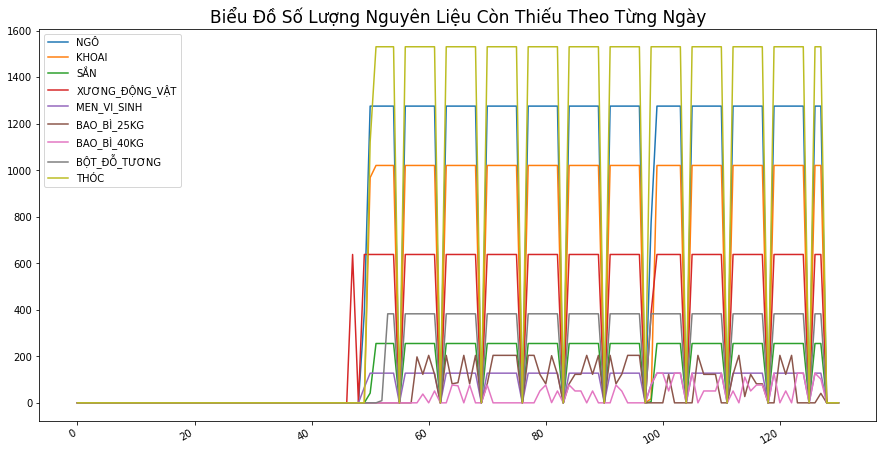

In [109]:
for d in range(len(history_missing_ingredient)):
    if d > (action_date - start_date).days:
        for k, v in dic_soh_ingre.items():
            k = k.split("*")[0]
            if y_dict[k][d] > 0:
                if v["qty"] > 0 and v["hsd"] > (start_date + timedelta(days=d)) > v["valid"]:
                    if v["qty"] >= y_dict[k][d]:
                        v["qty"] -= y_dict[k][d]
                        y_dict[k][d] = 0
                    else:
                        y_dict[k][d] -= v["qty"]
                        v["qty"] = 0

for key in y_dict.keys():
    plt.plot(x, y_dict[key], label=key)
    plt.title("Biểu Đồ Số Lượng Nguyên Liệu Còn Thiếu Theo Từng Ngày", fontsize=17)
    plt.gcf().set_size_inches(15, 8)
    plt.gcf().autofmt_xdate()
    plt.legend()

### 2.3. Search for planned order release schedule

Tìm kiếm ngày cần nhập nguyên vật liệu để phục vụ cho sản xuất.
Kiểm tra từng ngày:
  + Nếu số lượng nguyên vật liệu thiếu = 0 => không cần nhập hàng
  + Nếu số lượng nguyên vật liệu thiếu > 0 và chúng ta có thể tính toán ngày nhập hàng sao cho thỏa mãn:

      a) Inventory day < shelf life 50% của nguyên vật liệu đó (tránh mua về không dùng hết phải bỏ đi)

      b) Điều kiện MOQ

In [110]:
import_info = []
temporal_y_dict = copy.deepcopy(y_dict)
cout = 0
active_index = (action_date - start_date).days


while not check_finish(temporal_y_dict):
    cout += 1
    for k, v in temporal_y_dict.items():
        start = start_insufficient(v[active_index:]) + active_index
        hsd = hsd_dict[k]
        end = int(start + hsd)
        end = min(end, len(v))
        amount_import = get_amount_import(v, start, end)
        if amount_import == 0:       # Ko thiếu thì ko cần check...
            continue
        if not check_moq(amount_import, df_items_fg.loc[df_items_fg['ITEM'] == k]['MOQ'].values[0]):
            raise Exception("Need to decrease tolerance, current use: {}".format(1))
        import_info.append({"item": k, "day": start_date + relativedelta(days=start), "amount": amount_import})
        for i in range(start, end):
            v[i] = 0
    if cout > 100:
        break

In [111]:
import_info

[{'item': 'NGÔ',
  'day': datetime.datetime(2023, 4, 10, 0, 0),
  'amount': 56008.66986794719},
 {'item': 'KHOAI',
  'day': datetime.datetime(2023, 4, 11, 0, 0),
  'amount': 44863.52340936373},
 {'item': 'SẮN',
  'day': datetime.datetime(2023, 4, 11, 0, 0),
  'amount': 11015.630852340932},
 {'item': 'XƯƠNG_ĐỘNG_VẬT',
  'day': datetime.datetime(2023, 4, 8, 0, 0),
  'amount': 8928.571428571428},
 {'item': 'MEN_VI_SINH',
  'day': datetime.datetime(2023, 4, 10, 0, 0),
  'amount': 1851.5714285714273},
 {'item': 'BAO_BÌ_25KG',
  'day': datetime.datetime(2023, 4, 19, 0, 0),
  'amount': 7331.386554621847},
 {'item': 'BAO_BÌ_40KG',
  'day': datetime.datetime(2023, 4, 20, 0, 0),
  'amount': 3003.3988595438195},
 {'item': 'BỘT_ĐỖ_TƯƠNG',
  'day': datetime.datetime(2023, 4, 13, 0, 0),
  'amount': 16846.26530612244},
 {'item': 'THÓC',
  'day': datetime.datetime(2023, 4, 11, 0, 0),
  'amount': 68468.83673469385},
 {'item': 'NGÔ',
  'day': datetime.datetime(2023, 6, 1, 0, 0),
  'amount': 29336.734693

# **C. Write Output**

This section is used to reformat output and write it to Excel

## **1. MRP**

In [112]:
import_info_tmt = copy.deepcopy (import_info)
df_import = pd.DataFrame(import_info_tmt)
df_import.to_csv ('mrp.csv',index=False)

## **2. Kế hoạch sản xuất, chuyển hàng từ nhà máy đến các kho**

### 2.1. MPS

In [113]:
#Chicken
X_Chicken_csv = X_Results_Chicken[(action_date-start_date).days:]
X_Chicken_csv = np.round(X_Chicken_csv)
df_X_Chicken_csv = pd.DataFrame(X_Chicken_csv)
df_X_Chicken_csv.to_csv('chicken_plan.csv',index=False)

#Sheep
X_SHEEP_csv = X_Results_SHEEP[(action_date-start_date).days:]
X_SHEEP_csv = np.round(X_SHEEP_csv)
df_X_SHEEP_csv = pd.DataFrame(X_SHEEP_csv)
df_X_SHEEP_csv.to_csv('sheep_plan.csv',index=False)

### 2.2. Kế hoạch chuyển hàng từ nhà máy đến các kho

In [114]:
Y_Results_Chicken = Y_Results_Chicken.reshape(-1,4)
Y_Chicken_csv = Y_Results_Chicken[(action_date-start_date).days:]
Y_Chicken_csv = np.round(Y_Chicken_csv)
df_Y_Chicken_csv = pd.DataFrame(Y_Chicken_csv)
df_Y_Chicken_csv.to_csv('chicken_plan_warehouse.csv',index=False)

Y_Results_SHEEP = Y_Results_SHEEP.reshape(-1,4)
Y_SHEEP_csv = Y_Results_SHEEP[(action_date-start_date).days:]
Y_SHEEP_csv = np.round(Y_SHEEP_csv)
df_Y_SHEEP_csv = pd.DataFrame(Y_SHEEP_csv)
df_Y_SHEEP_csv.to_csv('SHEEP_plan_warehouse.csv',index=False)

## **3. Expired Items**

In [115]:
dic_soh_ingre_tmd = copy.deepcopy(dic_soh_ingre)
out_of_date = dict()
for k, v in dic_soh_ingre_tmd.items():
  k = k.split('*')[0]
  if k not in out_of_date.keys():
    out_of_date[k] = v['qty']
  else :
    out_of_date[k] += v['qty']
out_of_date


out_of_date_=[[k,v] for k,v in out_of_date.items()]
df_out_of_date = pd.DataFrame(out_of_date_)
df_out_of_date.to_csv('RM_out_of_date.csv',index=False)